In [1]:
using Pkg
Pkg.activate("C:\\Users\\Alex\\Desktop\\repo\\2612\\0903\\dynamical-systems\\env\\integrate\\")

  Activating project at `C:\Users\Alex\Desktop\repo\2612\0903\dynamical-systems\env\integrate`


In [3]:
using StaticArrays, DifferentialEquations, DynamicalSystems

E, x, y  = 0..40, 0..1,  0..1
box = E × x × y
using CairoMakie

In [4]:
@inbounds U(y, p) = p[8] + p[9] / ( 1.0 + exp( -50.0 * (y - p[7]) ) )
@inbounds σ(x, p) = 1.0 / ( 1.0 + exp( -20.0 * (x-p[6]) ) )
@inbounds g(E, x, y, p, U_) = log( 1.0 + exp( (p[5] * U_ * x * E + p[11]  ) / (p[1]) ) )

@inbounds function TM(u, p, t)
    
    U_ = U(u[3], p)
    
    du1 = (-u[1] + p[1] * g(u[1], u[2], u[3], p, U_) ) / p[2]
    du2 = (1.0 - u[2]) / p[3] - U_*u[2]*u[1]
    du3 = (-u[3])/p[4] + p[10] * σ(u[2], p)
    
    return SVector(du1, du2, du3)
end


@inbounds function jacob_TM_(u, p, t)
    
    U(y, p, exp50) = p[8] + p[9] / ( 1.0 + exp50 )
    U_y(y, p, exp50) = (50.0 * p[9] * exp50) / (1.0 + exp50)^2
    g(E, x, y, p, U_) = exp((p[5]  * U_ * x * E + p[11]) / p[1])
    σ_der(x, p) = exp( (-20.0) * (x - p[6]) )
    exp50 = exp(-50.0 * (u[3] - p[7]))
    
    U_ = U(u[3], p, exp50)
    Uy = U_y(u[3], p, exp50)
    g_ = g(u[1], u[2], u[3], p, U_)
    σ_deri = σ_der(u[2], p)
    
    g_plus = 1.0 + g_
    g_mult = g_ * U_
    g_plus_mult = p[2] * (g_plus)
    u1p5 = p[5] * u[1]
    Uyu2 = Uy * u[2]
    
    E_E = (-1.0 + ((J * u[2] * g_mult)) / (g_plus) ) / p[2]
    E_x = (u1p5 * g_mult) / (g_plus_mult)
    E_y = (u1p5 * Uyu2 * g_) / (g_plus_mult)
    
    x_E = -U_ * u[2]
    x_x = -1.0 / p[3] - U_ * u[1]
    x_y = -Uyu2 * u[1]
    
    y_x = 20.0 * p[10] * σ_deri / (1.0 + σ_deri)^2
    y_y = -1.0/p[4]
    
    SMatrix{3,3}(E_E, x_E, 0.0,
        E_x, x_x, y_x,
        E_y, x_y, y_y)
end;

In [108]:
t = 5000; tt = 1000; tstep = 0.001
integ_set = (alg = RK4(), adaptive = false, dt = tstep);

In [109]:
const τ = 0.013;  const τD = 0.080;  const τy = 3.3;  const J = 3.07;  const β = 0.300
const xthr = 0.75; const ythr = 0.4
const α = 1.58; const ΔU0 = 0.305;

U0 = 0.264
I0 = -1.71

-1.71

In [110]:
p = [α, τ, τD, τy, J, xthr, ythr, U0, ΔU0, β, I0]

u0_hc = tr_h[end] #[8.72034680045247, 0.7331126472077776, 0.439429357635731]

3-element SVector{3, Float64} with indices SOneTo(3):
 8.662493395672337
 0.7305245546200919
 0.438806632016064

In [111]:
println(u0_hc)

[8.662493395672337, 0.7305245546200919, 0.438806632016064]


Double period
[5.703960241685617, 0.7514489808165569, 0.44878444809941526]

Homoclinic
[6.154581240346446, 0.7336262321641008, 0.4403107515803029]

In [112]:
ds_hc = CoupledODEs(TM, u0_hc, p, diffeq = integ_set)
tr_h, trange = trajectory(ds_hc, t, Δt = tstep; Ttr = tt)

(3-dimensional StateSpaceSet{Float64} with 5000001 points, 1000.0:0.001:6000.0)

In [113]:
fp, eigs, stable = fixedpoints(ds_hc, box, jacob_TM_)

(3-dimensional StateSpaceSet{Float64} with 1 points, Vector{ComplexF64}[[-6.281793982492668 + 0.0im, 2.150138101919102 - 13.699346088541535im, 2.150138101919102 + 13.699346088541535im]], Bool[0])

In [114]:
fp

3-dimensional StateSpaceSet{Float64} with 1 points
 8.32745  0.73865  0.439057

In [115]:
eigs[1]

3-element Vector{ComplexF64}:
 -6.281793982492668 + 0.0im
  2.150138101919102 - 13.699346088541535im
  2.150138101919102 + 13.699346088541535im

In [116]:
ts, tf = 1, 5000000

(1, 5000000)

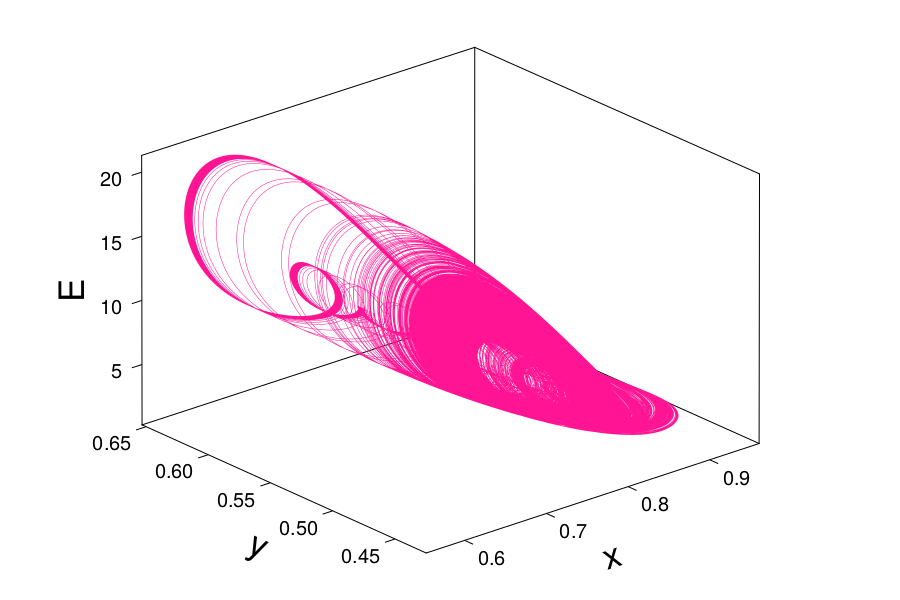

In [121]:
f = Figure(resolution = (900, 600))
axis3 = Axis3(f[1, 1], xlabel = "x", ylabel = "y", zlabel = "E",
                xlabelsize = lb_size, ylabelsize = lb_size, zlabelsize = lb_size,
                xticklabelsize = tck_size, yticklabelsize = tck_size, zticklabelsize = tck_size,
                xgridvisible = false, ygridvisible = false, zgridvisible = false)
idx, idy, idz = 2, 3, 1

lines!(axis3, tr_h[ts:tf, idx], tr_h[ts:tf, idy], tr_h[ts:tf,idz], linewidth = 0.5, color = :deeppink)
f

In [118]:
lb_size = 35; tck_size = 20;

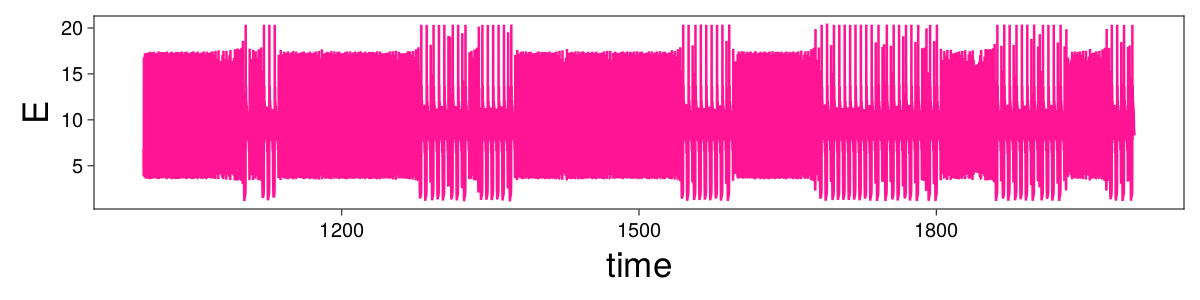

In [97]:
ts, tf = 1, 1000000

f = Figure(resolution = (1200, 300))
axis = Axis(f[1, 1], xlabel = "time", ylabel = "E",
            xlabelsize = lb_size, ylabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false)
#lines!(axis, trange[ts:tf], tr_dp[ts:tf, 1], linewidth = 2.5, color = :blue)
lines!(axis, trange[ts:tf], tr_h[ts:tf, 1], linewidth = 2.5, color = :deeppink)
f